Using cpu
Training dataset length: 80


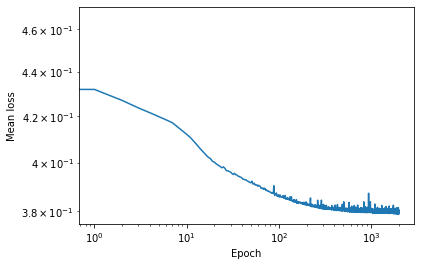

In [183]:
import numpy as np
import pickle

from scipy import ndimage
import scipy.optimize as opt
from scipy import signal

import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation, rc

from IPython.display import HTML
%matplotlib inline

# Import custom modules
from lib.FramesDataset import FramesDataset
from lib import network

# Global variables
HIDDEN_UNITS = 1600
FRAME_SIZE = 15
WARMUP = 4
MODE = 'hierarchical'
T_STEPS = 20

PATHS = [
    './models/hierarchical-15framesize-20tsteps-4warmup-2000epochs-1600units-0.001lr-0.25gradclip-1e-06L1/0.2beta'
]
PATH = PATHS[0]

# Set device to use on network
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", DEVICE)

# Load previously trained model
model = network.RecurrentTemporalPrediction.load(
    hidden_units = HIDDEN_UNITS,
    frame_size = FRAME_SIZE,
    warmup = WARMUP,
    mode = MODE,
    path = PATH + '.pt'
)

# Load dataset
train_dataset = FramesDataset('./datasets/processed_dataset_15px_20tsteps.npy', 'train', WARMUP)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
print("Training dataset length:", len(train_dataset))

# Plot loss history
with open(PATH + '.pickle', 'rb') as p:
    loss_history = pickle.load(p)
    
plt.loglog(loss_history);
plt.xlabel('Epoch')
plt.ylabel('Mean loss')
plt.show() 

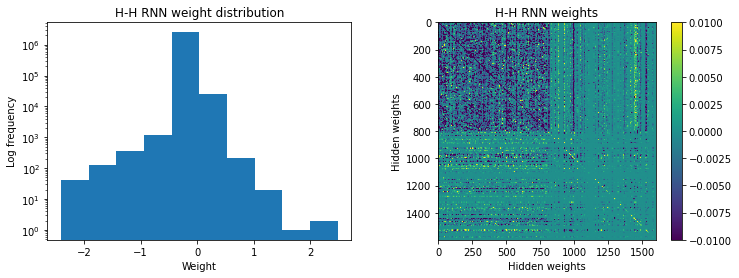

In [66]:
# Plot weight matrices and weights distribution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/3))

axs[0].hist(model.rnn.weight_hh_l0.detach().numpy().flat, log=True)
axs[0].set_xlabel('Weight')
axs[0].set_ylabel('Log frequency')
axs[0].set_title('H-H RNN weight distribution')

im = axs[1].imshow(model.rnn.weight_hh_l0.detach().numpy(), vmin=-0.01, vmax=0.01)
axs[1].set_xlabel('Hidden weights')
axs[1].set_ylabel('Hidden weights')
axs[1].set_title("H-H RNN weights")
plt.colorbar(im)

In [32]:
# Produce spike-triggered average
def max_abs_normalize (arr):
    return arr / np.max(np.abs(arr))

def normalize (arr):
    return np.array([
        (lambda a: (a-np.mean(a)) / np.std(a))(b)
        for b in arr
    ])

n_rand_stimuli = 1000

stimuli = {}
unit_activity = {}

for i in range(HIDDEN_UNITS):
    stimuli[i] = []
    unit_activity[i] = []

for i in range(n_rand_stimuli):
    if i % 10 == 9:
        print('Random noise trial {}'.format(i+1))
    
    noise_shape = (1, WARMUP+T_STEPS, FRAME_SIZE**2)
    noise = np.random.normal(loc=0, scale=1, size=noise_shape)
    noise = torch.Tensor(noise).to(DEVICE)
    
    _, hidden_state = model(noise)
    
    for t_step in range(WARMUP, WARMUP+T_STEPS):
        units = hidden_state[0, t_step, :] # Output t_step
        for i, unit in enumerate(units):
            if unit > 0:
                weighted_stimulus = noise[0, t_step, :] * unit
                stimuli[i].append(weighted_stimulus.cpu().detach().numpy())
                unit_activity[i].append(unit.cpu().detach().numpy())
                
averaged_stimuli_group1 = [], []
averaged_stimuli_group2 = [], []

for i in range(HIDDEN_UNITS):
    if i % 100 == 99:
        print('Averaging across hidden unit {}'.format(i+1))
    
    stimuli_len = len(stimuli[i])
    if stimuli_len:
        stimulus = np.sum(stimuli[i], 0)/np.sum(unit_activity[i]) # Weighted average

        if i < HIDDEN_UNITS//2:
            averaged_stimuli_group1[0].append(stimulus)
            averaged_stimuli_group1[1].append(i)
        else:
            averaged_stimuli_group2[0].append(stimulus)
            averaged_stimuli_group2[1].append(i)
averaged_stimuli_group1 = np.array(averaged_stimuli_group1[0]), np.array(averaged_stimuli_group1[1])
averaged_stimuli_group2 = np.array(averaged_stimuli_group2[0]), np.array(averaged_stimuli_group2[1])
        
print('Finished averaging stimuli')

Random noise trial 10
Random noise trial 20
Random noise trial 30
Random noise trial 40
Random noise trial 50
Random noise trial 60
Random noise trial 70
Random noise trial 80
Random noise trial 90
Random noise trial 100
Random noise trial 110
Random noise trial 120
Random noise trial 130
Random noise trial 140
Random noise trial 150
Random noise trial 160
Random noise trial 170
Random noise trial 180
Random noise trial 190
Random noise trial 200
Random noise trial 210
Random noise trial 220
Random noise trial 230
Random noise trial 240
Random noise trial 250
Random noise trial 260
Random noise trial 270
Random noise trial 280
Random noise trial 290
Random noise trial 300
Random noise trial 310
Random noise trial 320
Random noise trial 330
Random noise trial 340
Random noise trial 350
Random noise trial 360
Random noise trial 370
Random noise trial 380
Random noise trial 390
Random noise trial 400
Random noise trial 410
Random noise trial 420
Random noise trial 430
Random noise trial 4

In [203]:
# Virtual physiology

def plot_grating_animation (gratings): # Will only work when called (or output called)
                                       # at end of notebook
    fig = plt.figure(dpi=40)
    init_data = gratings.detach().numpy()[0, 0].reshape(FRAME_SIZE, FRAME_SIZE)
    im = plt.imshow(init_data, cmap='gray')
    plt.title("Grating stimulus", size=20)
    plt.close()
    def animate(i):
        im_data = gratings.detach().numpy()[0, i].reshape(FRAME_SIZE, FRAME_SIZE)
        im.set_array(im_data)
        return [im]
    anim = animation.FuncAnimation(
        fig, animate,
        frames=WARMUP+T_STEPS, interval=100
    )
    
    return HTML(anim.to_jshtml())

def get_f_value (activity):
    # Fit to sine
    def func(x, a, b, c, d):
        return a*np.sin(b*x + c) + d

    params = []
    mse = []
    increment = []

    offset = 5 # Discard how much of beginning of activity

    # Because the unit output has a floor of 0, the curve optimizer function might
    # fail to fit the function unless we shift the unit's response up
    # Shift it up by 0-125, returning the increment (shift), parameters and MSE for each increment
    for i in range(0, 125, 10):
        x = np.arange(len(activity[offset:]))
        y = np.array(activity[offset:]) + i

        # In case it fails to find optimal parameters, wrap in a try block
        try:
            bounds = (
                [-np.inf, 0.5, -np.inf, -np.inf],
                [np.inf, np.inf, np.inf, np.inf] # Set lower bound of 0.5 for frequency
            )
            
            optimizedParameters, pcov = opt.curve_fit(func, x, y, method='trf', bounds=bounds);
            y_est = func(x, *optimizedParameters)
            
            params.append(optimizedParameters)
            mse.append(np.mean(np.sum((y-y_est)**2)))
            increment.append(i)
        except:
            continue

    # Return false if no good fits were found for any combination
    if len(params):
        # Get the index of the lowest MSE, use this to find the
        # Corresponding parameters used
        idx = np.argmin(mse)
        best_params = params[idx]
        best_i = increment[idx]
        best_mse = mse[idx]

        f0 = np.mean(activity[offset:]) # Average unit activity
        f1 = (abs(best_params[0])) # Absolute of the amplitude of the fitted sine

        y_est = func(np.arange(len(activity[offset:])), *best_params) - best_i
    
        if best_mse <= 10 and f0 != 0: # Reject f values for those units with poor sine fits
            return f1/f0, y_est        # as these are unlikely to be reliable
        else:
            return False, False
    else:
        return False, False

def generate_gratings (frequency, rotation):
    gratings = []
    for i in range(WARMUP+T_STEPS+1):
        extended_val = 4 # For a full field grating, make it 4 times larger than
                         # the frame so it can be cropped when rotated and still be full-field
        extended_size = FRAME_SIZE*extended_val
        crop_slice = slice( # Crop extended size grating to be the same size as the frame
            (extended_size-FRAME_SIZE)//2, (extended_size-FRAME_SIZE)//2+FRAME_SIZE
        )
        
        phase = np.pi*-i*0.5 # Shift  by -pi/2 each timestep

        x_range = np.linspace(0, 2*np.pi, num=extended_size)
        y = np.sin(x_range*frequency*extended_val + phase)

        grating = np.repeat(y, extended_size, axis=0).reshape((extended_size, extended_size))
        grating = ndimage.rotate(grating, rotation-90, reshape=False) # -90 to correct for fact that 'default' is 90deg/horizontal
        grating = grating[crop_slice, crop_slice]
        grating = grating.reshape(FRAME_SIZE**2)
        gratings.append(grating)
    
    gratings = np.array([gratings])
    gratings = torch.Tensor(gratings).to(DEVICE)

    return gratings

# Returns a dict of grating responses { unit_idx: responses_array }
def get_grating_responses (model, grating, unit_idxs):
    responses = {}
    for idx in unit_idxs:
        responses[idx] = []
    
    _, hidden_state = model(grating)
    for t_step in range(WARMUP, WARMUP+T_STEPS):
        for idx in unit_idxs:
            unit_activity = hidden_state[0, t_step, idx]
            responses[idx].append(unit_activity.detach().numpy())
            
    return responses

# Returns array of physiology data
# { "unit_idx", "tuning_curve", "sf", "orientation", "preferred_response", "f" }
def get_physiology_data (averaged_hidden_units):
    offset = 5 # Discard response to first 5 frames
    hidden_unit_rfs, hidden_unit_idxs = averaged_hidden_units
    
    physiology_data = []

    spatial_frequencies = np.arange(0.5, 6.5, 0.5)
    orientations = np.arange(0, 190, 10)

    response_tuning_curves = {}
    for idx in hidden_unit_idxs:
        response_tuning_curves[idx] = np.zeros((len(spatial_frequencies), len(orientations)))

    for row, sf in enumerate(spatial_frequencies):
            for col, deg in enumerate(orientations):
                gratings = generate_gratings(sf, deg)
                grating_responses = get_grating_responses(model, gratings, hidden_unit_idxs)
                
                for idx in hidden_unit_idxs:
                    response_tuning_curves[idx][row, col] = np.mean(grating_responses[idx][offset:]) # Get mean response for that
                                                                                                     # sf, orientation combo
    print("Finished tuning curve")

    for i, unit_idx in enumerate(response_tuning_curves):
        tuning_curve = response_tuning_curves[unit_idx]
        
        sf_idx, orient_idx = np.where(tuning_curve >= np.max(tuning_curve))
        max_sf, max_orient = spatial_frequencies[sf_idx[0]], orientations[orient_idx[0]]
        
        gratings = generate_gratings(max_sf, max_orient)
        grating_response = get_grating_responses(model, gratings, hidden_unit_idxs)[unit_idx]

        f, y_est = get_f_value(grating_response)
        
        physiology_data.append({
            "unit_idx": unit_idx,
            "rf": hidden_unit_rfs[np.where(hidden_unit_idxs == unit_idx)[0]],
            "tuning_curve": tuning_curve,
            "sf": max_sf,
            "orientation": max_orient,
            "preferred_response": grating_response,
            "max_mean_response": np.mean(grating_response),
            "f": f,
            "y_est": y_est
        })

        if i % 100 == 99:
            print("Finished unit {} / {}".format(i+1, len(hidden_unit_idxs)))

    print("Finished all physiology data processing")

    return physiology_data

# Graphs is an array of ["rf", "tuning_curve", "preferred_response"]
def plot_physiology_data (unit, graphs):
    if "rf" in graphs:
        sta = normalize(unit["rf"])
        fig = plt.figure(dpi=40)
        plt.imshow(sta.reshape(FRAME_SIZE, FRAME_SIZE), cmap='gray')
        plt.title('Normalized SA', size=25)
        plt.show()

    if "tuning_curve" in graphs:
        spatial_frequencies = np.arange(0.5, 6.5, 0.5)
        orientations = np.arange(0, 190, 10)

        fig, ax = plt.subplots(dpi=100)
        plt.imshow(unit["tuning_curve"])
        plt.colorbar()
        plt.xlabel("Orientation")
        plt.xticks(range(len(orientations)), orientations, size=6) 
        plt.ylabel("SF")
        plt.yticks(range(len(spatial_frequencies)), spatial_frequencies, size=6)
        plt.title("Max unit activity as a function of orientation and SF", size=8)
        plt.show()

    if "preferred_response" in graphs:
        fig = plt.figure()
        plt.plot(unit["preferred_response"])
        if unit["f"]:
            plt.plot(np.arange(5, 20), unit["y_est"])
        plt.xlabel("Frame (phase)")
        plt.ylabel("Activity")
        plt.title(
            "Activity for SF = {}, orientation = {}, unit {}".format(
                unit["sf"], unit["orientation"], unit["unit_idx"]
            )
        )
        plt.show()

physiology_data_group1 = get_physiology_data(averaged_stimuli_group1)
physiology_data_group2 = get_physiology_data(averaged_stimuli_group2)

Finished tuning curve
Finished unit 100 / 770
Finished unit 200 / 770
Finished unit 300 / 770
Finished unit 400 / 770
Finished unit 500 / 770
Finished unit 600 / 770
Finished unit 700 / 770
Finished all physiology data processing
Finished tuning curve
Finished all physiology data processing


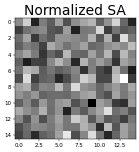

In [ ]:
# Spatial localisation of units

def generate_gabors (sf, orientation, gabor_size, row, col):
    # Code sample from https://stackoverflow.com/a/46892763
    def gkern(kernlen, std):
        gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
        gkern2d = np.outer(gkern1d, gkern1d)
        return gkern2d

    gabor_envelope = gkern(gabor_size, gabor_size/5)
    gratings = generate_gratings(sf, orientation).reshape(-1, FRAME_SIZE, FRAME_SIZE)

    im_width = FRAME_SIZE+gabor_size
    im = np.zeros((im_width, im_width)) # Padded size to frame + half of gabor width on each side
    im[row:row+gabor_size, col:col+gabor_size] = gabor_envelope # Set gabor envelope at x,y position
    im = im[gabor_size//2:FRAME_SIZE+gabor_size//2, gabor_size//2:FRAME_SIZE+gabor_size//2] # Crop to remove padding
    gabor = im * gratings.detach().numpy() # Convolve grating with gaussian kernel
    gabor = gabor.reshape((-1, FRAME_SIZE**2))
    gabor = torch.Tensor(gabor).unsqueeze(0)

    return gabor
unit = physiology_data_group2[8]
unit_idx = unit["unit_idx"]

plot_physiology_data(unit, ["rf", "tuning_curve", "preferred_response"])

spatial_responses = np.zeros((FRAME_SIZE, FRAME_SIZE))
for gabor_size in range(1, 21, 5):
    for row in range(FRAME_SIZE):
        for col in range(FRAME_SIZE):
            gabors = generate_gabors(unit["sf"], unit["orientation"], gabor_size, row, col)
            response = get_grating_responses(model, gabors, averaged_stimuli_group2[1])[unit_idx]
            spatial_responses[row, col] = np.mean(response[5:])
        print("Completed row {}".format(row+1))

    plt.imshow(spatial_responses)
    plt.colorbar()
    plt.title("Mean response for Gabor of width {}, std {}".format(gabor_size, gabor_size/5))
    plt.show()

Text(-0.025, 0.5, 'Postsynaptic unit')

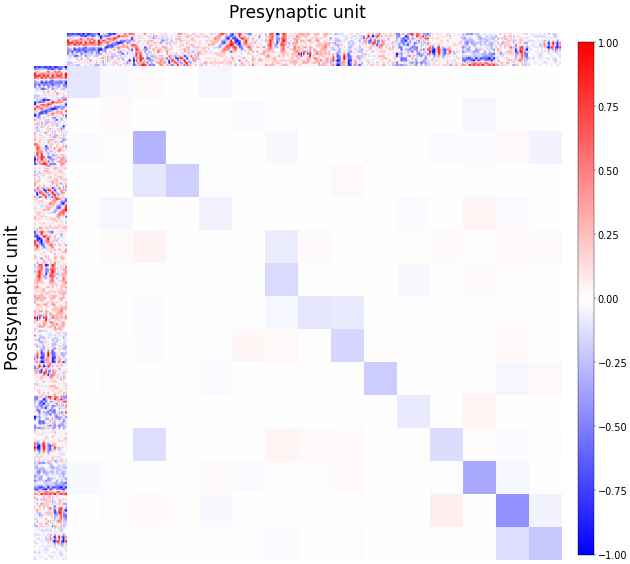

In [228]:
# Visualise connections between recurrent units
averaged_stimuli = averaged_stimuli_group1

starting_idx = 0
n_units = 15
units_slice = slice(starting_idx, starting_idx+n_units)

hh_indices = averaged_stimuli[1][units_slice]
hh_weights = model.rnn.weight_hh_l0.detach().numpy()
hh_weights_subset = np.zeros(shape=(n_units, n_units))

for row in range(n_units):
    for col in range(n_units):
        hh_weights_subset[row, col] = hh_weights[hh_indices[row], hh_indices[col]]

sta_RFs = max_abs_normalize(averaged_stimuli_group1[0][units_slice])

cols = n_units + 1
rows = n_units + 1

fig, f_axs = plt.subplots(
    dpi=35,
    ncols=cols,
    nrows=rows,
    figsize=(cols, rows),
    gridspec_kw=dict(wspace=0.0, hspace=0.0,
                     top=1. - 0.5 / (rows + 1), bottom=0.5 / (rows + 1),
                     left=0.5 / (cols + 1), right=1 - 0.5 / (cols + 1)),
)
gs = f_axs[0, 0].get_gridspec()

for axs in f_axs[1:, 1:]:
    for ax in axs:
        ax.remove()
axbig = fig.add_subplot(gs[1:, 1:])
axbig.set_axis_off()
im = axbig.imshow(hh_weights_subset, cmap='bwr', vmax=1, vmin=-1)

cbaxes = fig.add_axes([1, 0.04, 0.03, 0.915]) 
cb = plt.colorbar(im, cax = cbaxes)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)

count = 0
for ax_row in f_axs:
    for ax in ax_row:
        ax.set_axis_off()
        
        if count > 0 and count < n_units+1: # X-axis row
            unit_n = count-1
        elif count % (n_units+1) == 0: # Y-axis row
            unit_n = count//(n_units+1) - 1
        else:
            unit_n = -1
            
        if unit_n > -1:
            unit = np.reshape(sta_RFs[unit_n], (FRAME_SIZE, FRAME_SIZE))
            ax.imshow(unit, cmap='bwr')
            
        count += 1
        
fig.text(0.5, 1, 'Presynaptic unit', ha='center', fontsize=35)
fig.text(-0.025, 0.5, 'Postsynaptic unit', va='center', rotation='vertical', fontsize=35)

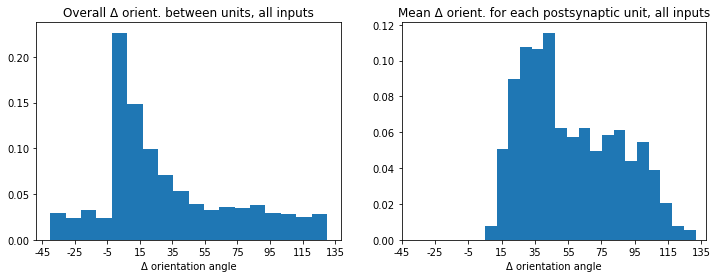

[Text(0, 0, '-45'),
 Text(20, 0, '-25'),
 Text(40, 0, '-5'),
 Text(60, 0, '15'),
 Text(80, 0, '35'),
 Text(100, 0, '55'),
 Text(120, 0, '75'),
 Text(140, 0, '95'),
 Text(160, 0, '115'),
 Text(180, 0, '135')]

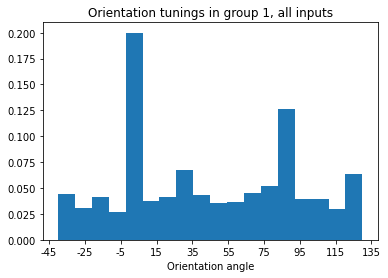

In [159]:
# Plot distribution of connections

averaged_stimuli = averaged_stimuli_group1

# Get subset of weights for those units which have STA estimates
weights = model.rnn.weight_hh_l0.cpu().detach().numpy()
unit_idxs = averaged_stimuli[1]
unit_idxs_inhib = averaged_stimuli[1][:72]
unit_idxs_excit = averaged_stimuli[1][72:]
weights_subset = weights[unit_idxs, :] # Rows
weights_subset = weights_subset[:, unit_idxs] # Columns

# Shuffle to see if there's any real effect (proto stats-test)
if False:
    np.random.shuffle(weights_subset)
    np.random.shuffle(np.transpose(weights_subset))

# Normalize weights and find threshold (greater than 2 std's)
weights_subset = (weights_subset-np.mean(weights_subset)) / np.std(weights_subset)
threshold = 1

orientation_deltas = []
mean_orientation_deltas = []

for post_unit_idx in range(len(unit_idxs)):
    unit_orientation_deltas = []
    for pre_unit_idx in range(len(unit_idxs)):
        if abs(weights_subset[post_unit_idx, pre_unit_idx]) >= threshold:
            pre_unit = physiology_data_group1[pre_unit_idx]
            post_unit = physiology_data_group1[post_unit_idx]
            
            a1, a2 = pre_unit["orientation"], post_unit["orientation"]
            adelta = 180 - abs(abs(a1 - a2) - 180)
            orientation_deltas.append(adelta)
            unit_orientation_deltas.append(adelta)
    if len(unit_orientation_deltas):
        mean_orientation_deltas.append(np.mean(unit_orientation_deltas))

orientation_deltas = np.array(orientation_deltas)
mean_orientation_deltas = np.array(mean_orientation_deltas)
        
shift = 45
        
shifted_orientation_deltas = (orientation_deltas+shift)%180
shifted_mean_orientation_deltas = (mean_orientation_deltas+shift)%180

weights_ods = np.ones_like(shifted_orientation_deltas) / float(len(orientation_deltas))
weights_shifted_ods = np.ones_like(shifted_mean_orientation_deltas) / float(len(mean_orientation_deltas))
    
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/3))
axs[0].hist(shifted_orientation_deltas, bins=18, weights=weights_ods)
axs[0].set_title("Overall Δ orient. between units, all inputs")
axs[0].set_xlabel("Δ orientation angle")
axs[0].set_xticks(np.arange(0, 200, 20))
axs[0].set_xticklabels(np.arange(0-shift, 200-shift, 20))

axs[1].hist(shifted_mean_orientation_deltas, bins=18, weights=weights_shifted_ods)
axs[1].set_title("Mean Δ orient. for each postsynaptic unit, all inputs")
axs[1].set_xlabel("Δ orientation angle")
axs[1].set_xticks(np.arange(0, 200, 20))
axs[1].set_xticklabels(np.arange(0-shift, 200-shift, 20))

plt.show()

orientations = []
for i in range(len(unit_idxs)):
    orientations.append(physiology_data_group1[i]["orientation"])
orientations = np.array(orientations)
weights = np.ones_like(orientations) / float(len(orientations))

fig, ax = plt.subplots()
ax.hist((orientations+shift)%180, bins=18, weights=weights)
ax.set_title("Orientation tunings in group 1, all inputs")
ax.set_xlabel("Orientation angle")
ax.set_xticks(np.arange(0, 200, 20))
ax.set_xticklabels(np.arange(0-shift, 200-shift, 20))

Text(0.5, 0.98, 'F values (> 1 indicates a simple cell)')

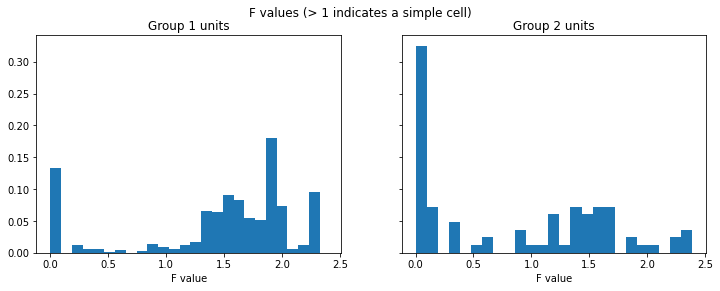

In [160]:
outlier_thresh = 5

f_values_1 = []
for i in range(len(averaged_stimuli_group1[1])):
    f_values_1.append(physiology_data_group1[i]["f"])
f_values_1 = np.array(f_values_1)
f_values_1 = f_values_1[f_values_1 < outlier_thresh]
weights_1 = np.ones_like(f_values_1) / float(len(f_values_1))
    
f_values_2 = []
for i in range(len(averaged_stimuli_group2[1])):
    f_values_2.append(physiology_data_group2[i]["f"])
f_values_2 = np.array(f_values_2)
f_values_2 = f_values_2[f_values_2 < outlier_thresh]
weights_2 = np.ones_like(f_values_2) / float(len(f_values_2))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/3), sharex=True, sharey=True)
axs[0].hist(f_values_1, bins=25, weights=weights_1)
axs[0].set_title("Group 1 units")
axs[0].set_xlabel("F value")
axs[1].hist(f_values_2, bins=25, weights=weights_2)
axs[1].set_title("Group 2 units")
axs[1].set_xlabel("F value")
fig.suptitle('F values (> 1 indicates a simple cell)')

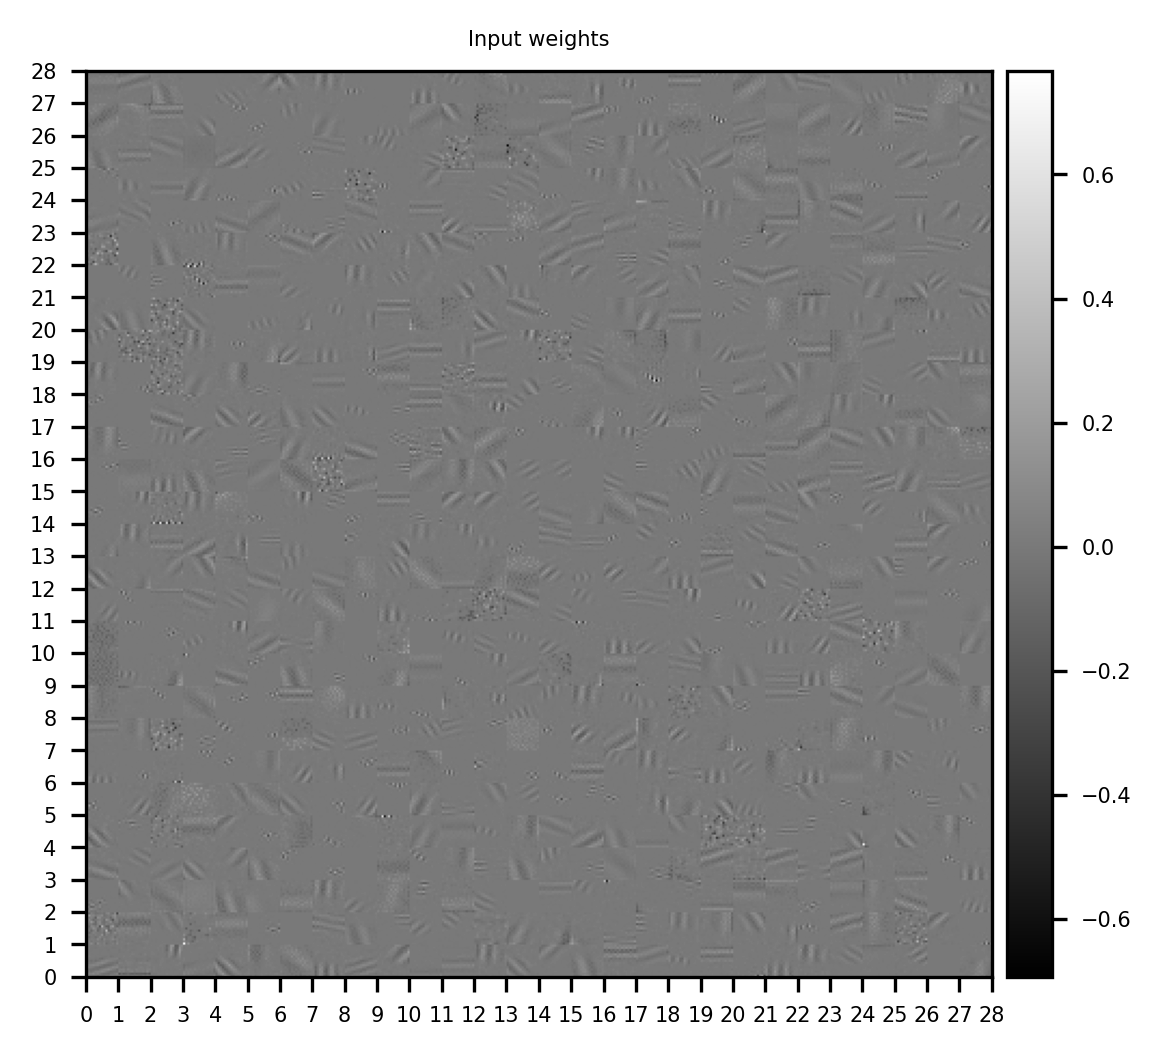

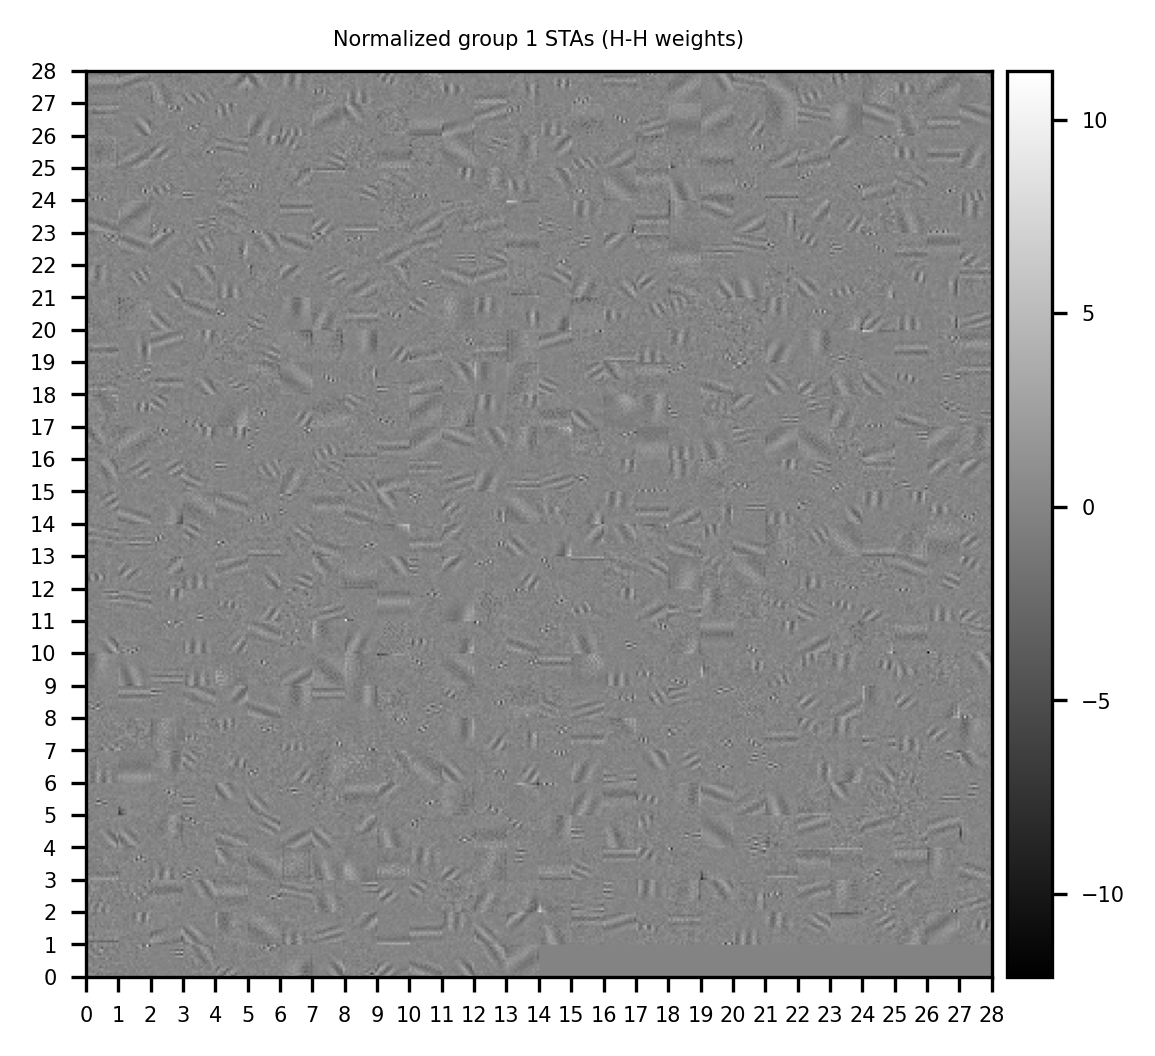

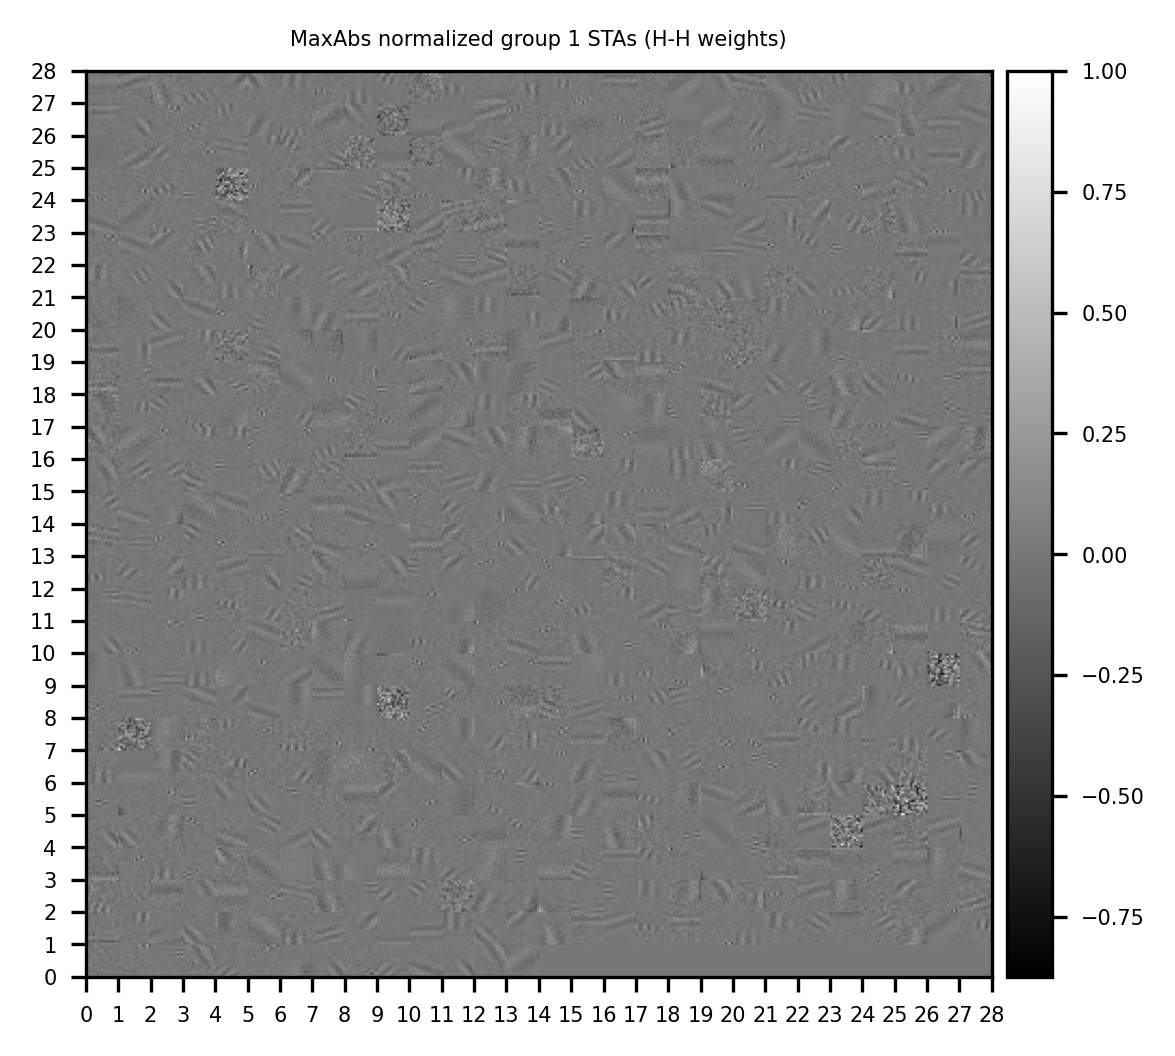

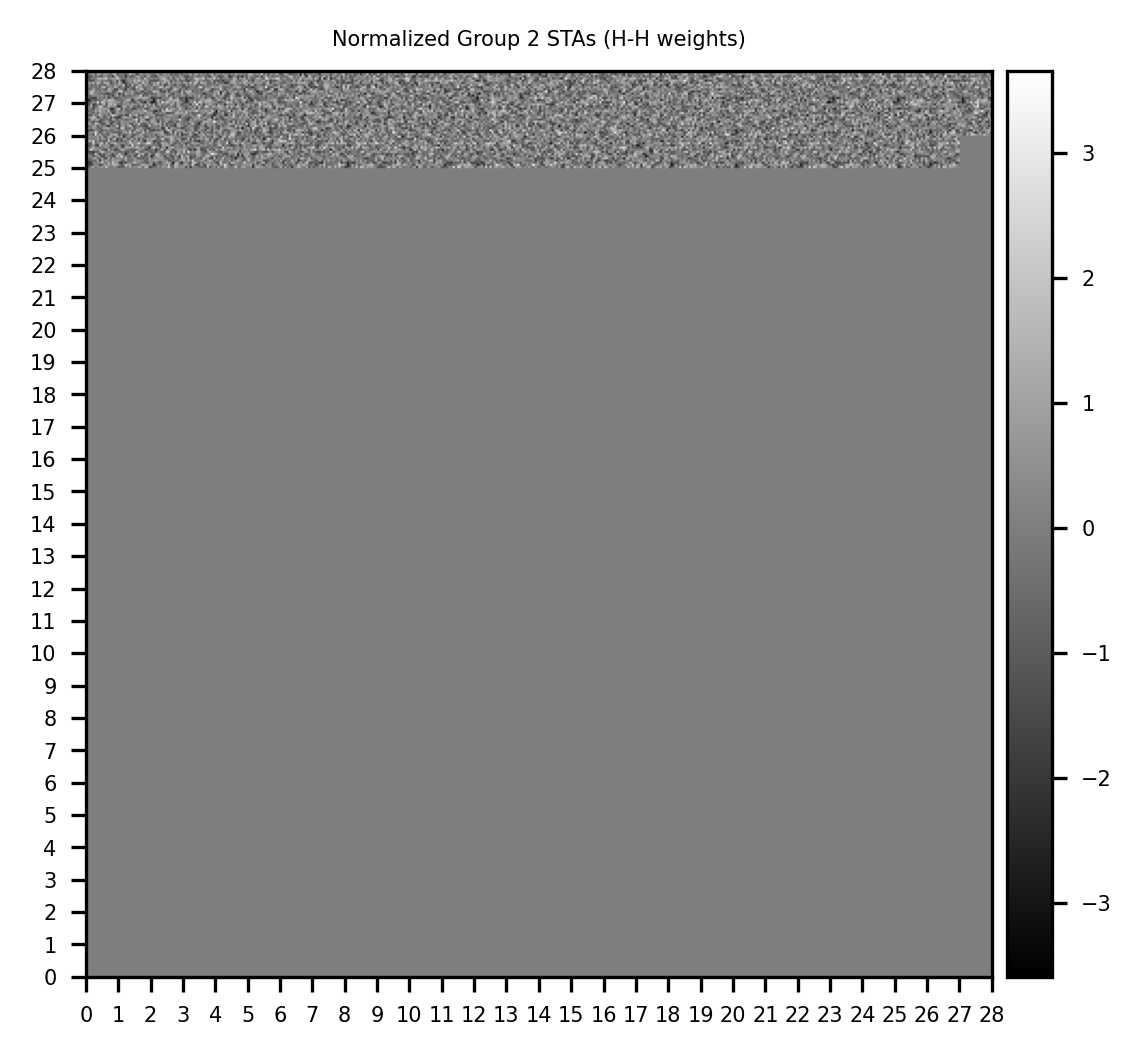

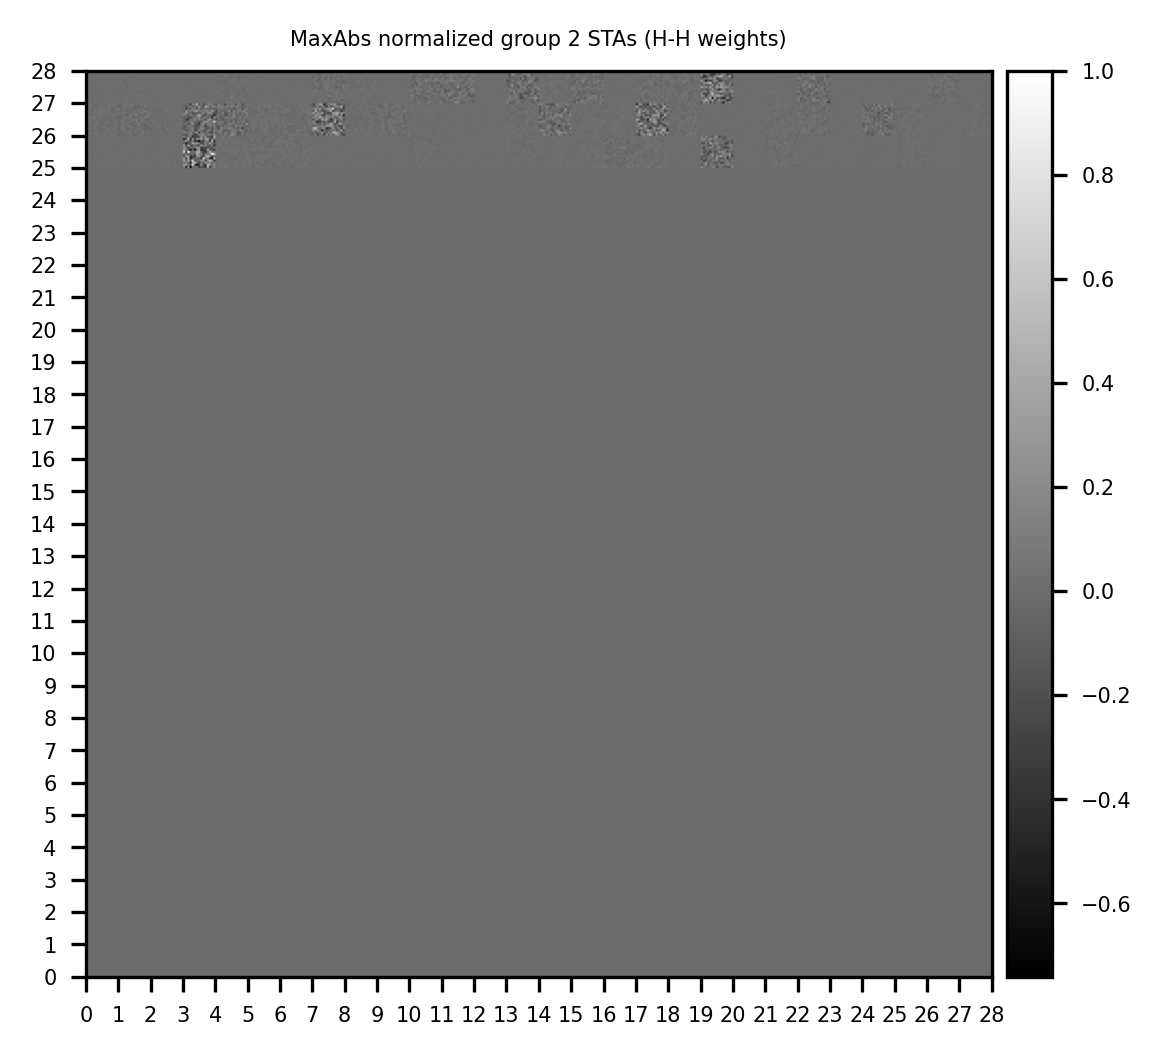

In [33]:
#Plot spike triggered averages and input weights
def plot_weights (weights_array, rows, columns, offset = 0, title = ""):
    font_size = 5
    weights = weights_array[offset:offset+rows*columns, :]
    im = np.zeros((rows*FRAME_SIZE, columns*FRAME_SIZE))
    
    for row in range(rows):
        for column in range(columns):
            idx = row*columns + column
            hidden_unit_weights = np.zeros(FRAME_SIZE**2) # Pad image if no more weights to show
            if idx < len(weights):
                hidden_unit_weights = weights[idx]
            hidden_unit_weights = np.reshape(hidden_unit_weights, (FRAME_SIZE, FRAME_SIZE))
            im[row*FRAME_SIZE:(row+1)*FRAME_SIZE, column*FRAME_SIZE:(column+1)*FRAME_SIZE] = hidden_unit_weights

    fig, ax = plt.subplots(dpi=300)
    im_plt = plt.imshow(im, extent=[0, columns, 0, rows], cmap='gray')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb_plt = plt.colorbar(im_plt, cax=cax)
    cb_plt.ax.tick_params(labelsize=font_size)

    ax.set_xticks(np.arange(0, columns+1))
    ax.set_xticklabels(np.arange(0, columns+1), size=font_size)
    ax.set_yticks(np.arange(0, rows+1))
    ax.set_yticklabels(np.arange(0, rows+1), size=font_size)
    #ax.grid(which='major', color='w', linestyle='-', linewidth=0.5)
    ax.set_title(title, size=font_size)

rows, columns, offset = (28, 28, 0)
plot_weights(model.rnn.weight_ih_l0.cpu().detach().numpy(), rows, columns, offset, "Input weights")

plot_weights(normalize(averaged_stimuli_group1[0]), rows, columns, offset, "Normalized group 1 STAs (H-H weights)")
plot_weights(max_abs_normalize(averaged_stimuli_group1[0]), rows, columns, offset, "MaxAbs normalized group 1 STAs (H-H weights)")
plot_weights(normalize(averaged_stimuli_group2[0]), rows, columns, offset, "Normalized Group 2 STAs (H-H weights)")
plot_weights(max_abs_normalize(averaged_stimuli_group2[0]), rows, columns, offset, "MaxAbs normalized group 2 STAs (H-H weights)")